In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

## Config

In [5]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [6]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel level

In [7]:
# # Loading in human annotations with consensus annotation already created
# annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# # Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# # Sorting
# predicted_channels.sort_values('approximate_onset',inplace=True)
# # predicted_channels = predicted_channels[predicted_channels.stim == 0]
# annotations_df.sort_values('approximate_onset',inplace=True)

# # Creating a merged table with human and machine annotations based on approximate seizure onset time
# pred_channels_wannots = pd.merge_asof(predicted_channels,
#                                     annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
#                                     on='approximate_onset',by='Patient',
#                                     tolerance = 240,
#                                     direction='nearest')
# pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
# pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# # pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [8]:
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
# pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))
# # pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### Calculating clinician consensus


In [9]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))

In [10]:
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)>1)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]


note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)


### Data Prep

In [11]:
anntype='consensus'
mdl_anntype = 'loose'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))

In [12]:
# mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [13]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [14]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
# melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_spec',f'sec_chs_{mdl_anntype}_{anntype}_spec']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037',
       'CHOP041', 'CHOP045', 'CHOP049', 'HUP224', 'HUP225', 'HUP229',
       'HUP230', 'HUP235', 'HUP238', 'HUP246', 'HUP247', 'HUP249',
       'HUP250', 'HUP253', 'HUP257', 'HUP261', 'HUP263', 'HUP266',
       'HUP267', 'HUP273', 'HUP275', 'HUP288'], dtype=object)

In [15]:
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_loose_dice']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_loose_dice']
# tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_chs_loose_consensus_spec']
# val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_chs_loose_consensus_spec']

In [16]:
tune_preds_long

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.000000,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.054054,0.060606,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.067114,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.160494,0.167598,ueo_consensus_loose_dice,0.036810
1,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,0.000000,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.054054,0.060606,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.067114,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.160494,0.167598,ueo_consensus_loose_dice,0.036810
2,CHOP005,CHOP005,NRG,1.0,68881.53,68881.53,0.000000,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.054054,0.060606,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.067114,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.160494,0.167598,ueo_consensus_loose_dice,0.036810
3,CHOP005,CHOP005,WVNT,1.0,68881.53,68881.53,0.000000,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.054054,0.060606,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.067114,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.160494,0.167598,ueo_consensus_loose_dice,0.036810
4,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.006012,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.054795,0.061350,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.068027,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.162500,0.169492,ueo_consensus_loose_dice,0.037267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155995,HUP288,HUP288_phaseII,WVNT,0.0,251098.53,251098.53,2.993988,[],[],[],...,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,ueo_consensus_loose_dice,0.000000
155996,HUP288,HUP288_phaseII,AbsSlp,0.0,251098.53,251098.53,3.000000,[],[],[],...,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,ueo_consensus_loose_dice,0.000000
155997,HUP288,HUP288_phaseII,LSTM,0.0,251098.53,251098.53,3.000000,[RB01],"[RB01, RB02]",[RC01],...,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.333333,"[RA01, RA02, RB01, RB02, RC01]",0.333333,0.285714,ueo_consensus_loose_dice,0.000000
155998,HUP288,HUP288_phaseII,NRG,0.0,251098.53,251098.53,3.000000,[],[],[],...,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,ueo_consensus_loose_dice,0.000000


### Threshold sweeping

In [17]:
# fig,axs = plt.subplots(1,2)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
# axs[0].set_ylim((-.1,.7))
# axs[0].set_title('Onset Annots')
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
# axs[1].set_ylim((-.1,.7))
# axs[1].set_yticks([])
# axs[1].set_ylabel('')
# axs[1].set_title('Spread Annots')
# fig.suptitle(f'Model Annotator Agreement - {anntype}')
# fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [18]:
# fig,ax = plt.subplots()
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'WVNT')],x='threshold',y='dice',hue='Patient',errorbar=None,legend=True)
# fig.savefig(ospj(figpath,f'pt_WVNT_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [19]:
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='dice',hue='Patient',errorbar=None,)

### Tuning at the seizure level

#### Tuning and testing on onset

In [53]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold','ueo_chs_loose','ueo_consensus_chs']]

In [54]:
optimal_threshold_preds

,model,dice,Patient,stim,approximate_onset,threshold,ueo_chs_loose,ueo_consensus_chs
132,AbsSlp,0.235294,CHOP005,1.0,68881.53,0.198397,"[LI04, LI05, LI06, LI07, LI08, LI09, LI10, LK0...","[LK01, LK02, LK03, LK04]"
1881,LSTM,0.166667,CHOP005,1.0,68881.53,2.825651,"[LF08, LF09, LH01, LH02, LI04, LI05, LI06, LI0...","[LK01, LK02, LK03, LK04]"
1786,NRG,0.315789,CHOP005,1.0,68881.53,2.681363,"[LI04, LI05, LI06, LI07, LI08, LK02, LK03, LK0...","[LK01, LK02, LK03, LK04]"
419,WVNT,0.181818,CHOP005,1.0,68881.53,0.625251,"[LA01, LA02, LA03, LF07, LF08, LF09, LI04, LI0...","[LK01, LK02, LK03, LK04]"
2192,AbsSlp,0.444444,CHOP024,1.0,87579.25,0.288577,"[LF01, LF02, LF05, LF06]","[LE10, LF02, LF03, LF04, LF05]"
...,...,...,...,...,...,...,...,...
152407,WVNT,0.333333,HUP288,1.0,73007.74,0.607214,"[RA01, RA02, RB01, RB02, RC01, RC02, RE02, RE0...","[RA01, RA02]"
154088,AbsSlp,0.064516,HUP288,0.0,251098.53,0.132265,"[RA02, RA03, RA04, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02]"
154917,LSTM,0.307692,HUP288,0.0,251098.53,1.376754,"[RA01, RA02, RA03, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02]"
154194,NRG,0.307692,HUP288,0.0,251098.53,0.288577,"[RA01, RA02, RA03, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02]"


In [55]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice"]]])

In [56]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=3910.5, pvalue=1.4405472214909341e-05)
LSTM
MannwhitneyuResult(statistic=3190.0, pvalue=0.10989249711725683)
NRG
MannwhitneyuResult(statistic=3286.5, pvalue=0.04935728623439681)
WVNT
MannwhitneyuResult(statistic=3786.5, pvalue=0.00011049304339397801)


In [57]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

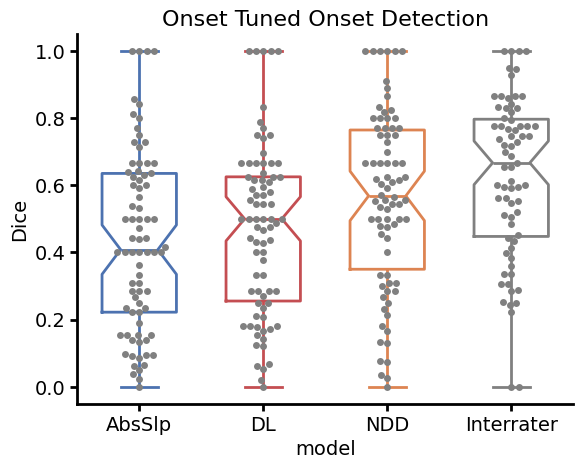

In [58]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
# bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
#                  order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
# sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
# sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
#               order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)

bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
# sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
#               order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylabel('Dice')
plt.title("Onset Tuned Onset Detection")
plt.savefig(ospj(figpath,'onset_tuned_onset_detection.pdf'))

In [60]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        _,p = sc.stats.ttest_ind(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(p)
_,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == 'NDD'].dice,consensus_annots.f1)
print(p)
multipletests(all_ps[:2])

AbsSlp NDD
0.0042083341907559095
NDD DL
0.03402381559649368
NDD Interrater
0.10762976772126372
0.10989249711725683


(array([ True,  True]),
 array([0.00839896, 0.03402382]),
 0.025320565519103666,
 0.025)

#### Testing on spread

In [27]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [28]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]
spread_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [29]:
all_ps = []
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice)
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

AbsSlp
MannwhitneyuResult(statistic=4283.5, pvalue=8.669884494555456e-09)
WVNT
MannwhitneyuResult(statistic=4341.5, pvalue=2.299967143672156e-09)
NRG
MannwhitneyuResult(statistic=3757.5, pvalue=0.00017311202444666632)
LSTM
MannwhitneyuResult(statistic=3835.5, pvalue=5.079042118163105e-05)


(array([ True,  True,  True,  True]),
 array([2.60096533e-08, 9.19986854e-09, 1.73112024e-04, 1.01578263e-04]),
 0.012741455098566168,
 0.0125)

Text(0.5, 1.0, 'Seizure Annotation Generalization to Spread')

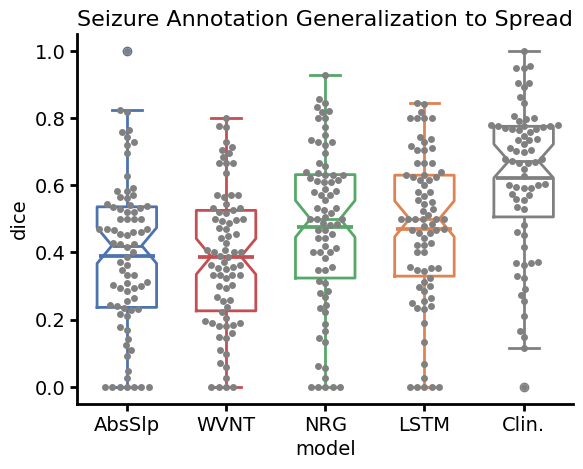

In [30]:
colors = sns.color_palette("deep", 4)
sns.swarmplot(spread_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.boxplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.despine()
plt.title("Seizure Annotation Generalization to Spread")

In [31]:
all_ps = []
for i_mdl in optimal_threshold_preds.model.unique():
    for j_mdl in optimal_threshold_preds.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],
                 val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=3042.0, pvalue=1.0)
AbsSlp LSTM
-0.35292511061463977
MannwhitneyuResult(statistic=2383.0, pvalue=0.01954685103097878)
AbsSlp NRG
-0.36501790438367143
MannwhitneyuResult(statistic=2339.5, pvalue=0.012811390345229927)
AbsSlp WVNT
0.022904837335858415
MannwhitneyuResult(statistic=3092.0, pvalue=0.8606881043667898)
LSTM AbsSlp
0.35292511061463977
MannwhitneyuResult(statistic=3701.0, pvalue=0.01954685103097878)
LSTM LSTM
0.0
MannwhitneyuResult(statistic=3042.0, pvalue=1.0)
LSTM NRG
-0.02458660658168661
MannwhitneyuResult(statistic=2969.0, pvalue=0.7971379147856019)
LSTM WVNT
0.39252146751701317
MannwhitneyuResult(statistic=3758.0, pvalue=0.011191047801070235)
NRG AbsSlp
0.36501790438367143
MannwhitneyuResult(statistic=3744.5, pvalue=0.012811390345229927)
NRG LSTM
0.02458660658168661
MannwhitneyuResult(statistic=3115.0, pvalue=0.7971379147856019)
NRG NRG
0.0
MannwhitneyuResult(statistic=3042.0, pvalue=1.0)
NRG WVNT
0.4030609460667001
Mannwhitney

### Tuning at the patient level

In [32]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','annot'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','annot'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list = threshold_list[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)

In [33]:
# threshold_list.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds.pkl'))

In [34]:
threshold_list

,Patient,model,threshold,dice
0,CHOP005,AbsSlp,0.198397,0.235294
1,CHOP005,LSTM,2.825651,0.166667
2,CHOP005,NRG,2.681363,0.315789
3,CHOP005,WVNT,0.625251,0.181818
4,CHOP024,AbsSlp,0.288577,0.444444
...,...,...,...,...
107,HUP275,WVNT,0.366733,0.217949
108,HUP288,AbsSlp,0.120240,0.092705
109,HUP288,LSTM,1.509018,0.296703
110,HUP288,NRG,0.288577,0.287179


In [35]:
tuned_thresholds = tune_preds_long[tune_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]
val_tuned_thresholds = val_preds_long[val_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]

#### Onset

In [36]:
all_plot_agreements = pd.concat([tuned_thresholds,consensus_annots[["model","dice"]]])

In [37]:
for mdl in tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice))
    print(cohens_d(consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=4321.5, pvalue=3.4926067547180684e-09)
1.1031580000541767
WVNT
MannwhitneyuResult(statistic=4226.5, pvalue=3.03586065075171e-08)
0.9767440700369924
NRG
MannwhitneyuResult(statistic=3804.5, pvalue=8.322619192214032e-05)
0.6801110860852023
LSTM
MannwhitneyuResult(statistic=3632.0, pvalue=0.0010411944208893254)
0.5471640036452543


In [38]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']

Text(0.5, 1.0, 'Patient-level Optimal Onset Threshold')

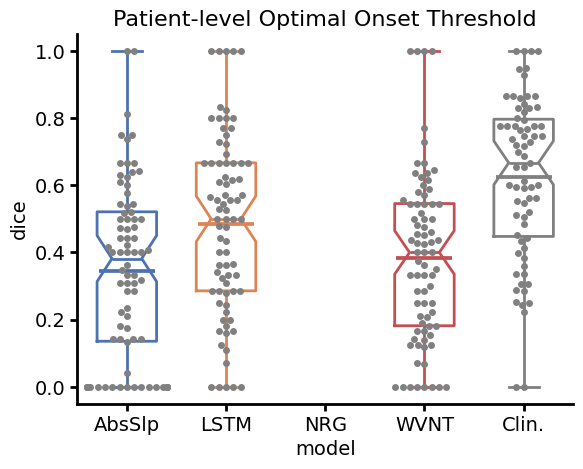

In [39]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Threshold")

In [40]:
all_ps = []
for i_mdl in tuned_thresholds.model.unique():
    for j_mdl in tuned_thresholds.model.unique():
        if (i_mdl != 'LSTM'):
            continue
        print(i_mdl,j_mdl)
        _,p = sc.stats.mannwhitneyu(tuned_thresholds[tuned_thresholds.model == i_mdl]['dice'],tuned_thresholds[tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(tuned_thresholds[tuned_thresholds.model == i_mdl]['dice'],
                 tuned_thresholds[tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)
multipletests(all_ps)

LSTM AbsSlp
0.5271583648924415
0.0016620160089983486
LSTM WVNT
0.39236155893470376
0.011099989303362557
LSTM NRG
0.1142798121911129
0.5025839609272315
LSTM LSTM
0.0
1.0


(array([ True,  True, False, False]),
 array([0.00663151, 0.03293171, 0.75257728, 1.        ]),
 0.012741455098566168,
 0.0125)

#### Spread

In [126]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [127]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=4182.5, pvalue=7.814666874590762e-08)
WVNT
MannwhitneyuResult(statistic=4279.0, pvalue=9.602076455675848e-09)
NRG
MannwhitneyuResult(statistic=3710.5, pvalue=0.0003477126041143967)
LSTM
MannwhitneyuResult(statistic=3794.0, pvalue=9.84743782203433e-05)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

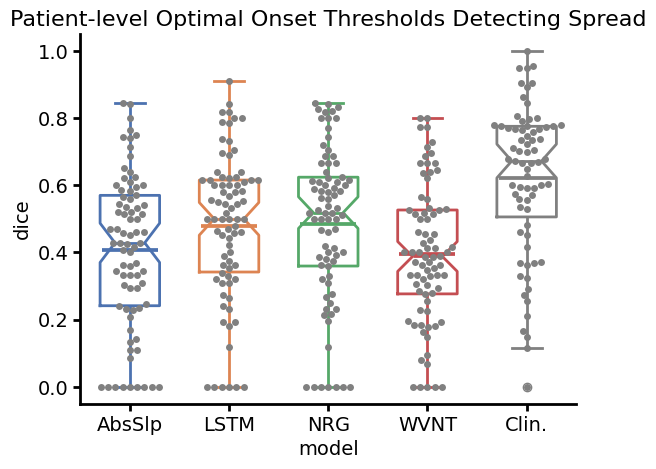

In [128]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

## KDE Model Predictions

In [41]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_opt.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0)]# & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [42]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_loose_dice > 0]
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_chs_strict.apply(lambda x: len(x) > 0)]

In [43]:
pred_channels_wdice

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice
136,CHOP041,CHOP041,NRG,0.0,416768.18,416768.18,0.330023,"[LJ07, LJ08, LJ09, LJ10, LE04, LE06, LE07, LE0...","[LB01, LB02, LC05, LC06, LE04, LE05, LE06, LE0...","[LJ01, LJ04, LJ05, LJ06, LJ07, LJ08, LJ09, LJ1...",...,0.000000,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.000000,0.000000,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.576271,0.671533,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.576271,0.671533
137,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.170148,"[LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ08, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,0.168421,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.169014,0.168421,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.521127,0.586826,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.521127,0.586826
138,CHOP041,CHOP041,WVNT,0.0,416768.18,416768.18,0.308808,"[LJ03, LJ04, LJ05, LJ06, LJ07, LJ08, LJ09, LJ1...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LB0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,0.266667,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.264151,0.266667,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.607735,0.631068,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.607735,0.631068
139,CHOP041,CHOP041,LSTM,0.0,416768.18,416768.18,1.210627,"[LJ03, LJ04, LJ05, LJ06, LJ07, LJ08, LJ09, LJ1...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LB0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,0.213333,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.214286,0.213333,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.654088,0.685083,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.654088,0.685083
24,CHOP049,CHOP049,LSTM,0.0,114973.49,114973.49,0.960658,"[LF01, LF02, LF03, LF04, LF05, LF06, LF07, LF0...","[LA02, LA03, LA04, LA05, LA06, LA07, LA08, LA0...","[LF01, LF02, LF03, LF04, LF05, LF06, LF07, LF0...",...,0.236025,"[LC01, LC02, LC03, LD07, LE10, LE09, LF01, LF0...",0.225352,0.236025,"[LC01, LC02, LC03, LC04, LC05, LC06, LD07, LF0...",0.446429,0.444444,"[LC01, LC02, LC03, LC04, LC05, LC06, LD07, LF0...",0.446429,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,HUP275,HUP275_phaseII,NRG,0.0,297659.44,297659.44,1.051875,[],[],"[LA09, LA10, LB09, LC09]",...,0.000000,"[LA09, LA10, LA11]",0.000000,0.000000,"[LA09, LA10, LA11, LB09, LB10, LB11, LC09, LC1...",0.571429,0.823529,"[LA09, LA10, LA11, LB09, LB10, LB11, LC09, LC1...",0.571429,0.823529
56,HUP288,HUP288_phaseII,LSTM,0.0,251098.53,251098.53,1.632608,"[RA01, RA02, RB01, RB02, RC01, RE01, RE02]","[RA01, RA02, RA03, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02, RB01, RB02, RC01, RC02, RE01, RE02]",...,0.307692,"[RA01, RA02]",0.444444,0.307692,"[RA01, RA02, RB01, RB02, RC01]",0.769231,0.588235,"[RA01, RA02, RB01, RB02, RC01]",0.769231,0.588235
57,HUP288,HUP288_phaseII,AbsSlp,0.0,251098.53,251098.53,0.183155,[RB01],"[RB01, RB02]","[RB01, RC01, RC02]",...,0.000000,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.500000,0.600000,"[RA01, RA02, RB01, RB02, RC01]",0.500000,0.600000
58,HUP288,HUP288_phaseII,WVNT,0.0,251098.53,251098.53,0.308165,"[RA01, RA02, RB01, RB02, RB03, RC01, RE01, RF0...","[RA01, RA02, RA03, RB01, RB02, RB03, RB04, RC0...","[RA01, RA02, RA03, RB01, RB02, RC01, RC02, RE0...",...,0.235294,"[RA01, RA02]",0.363636,0.235294,"[RA01, RA02, RB01, RB02, RC01]",0.454545,0.344828,"[RA01, RA02, RB01, RB02, RC01]",0.454545,0.344828


In [44]:
len(pred_channels_wdice.Patient.unique())

21

In [45]:
pred_type = 'ueo_any_loose_dice'

Text(0.5, 1.0, 'KDE Unsupervised Onset Annotation')

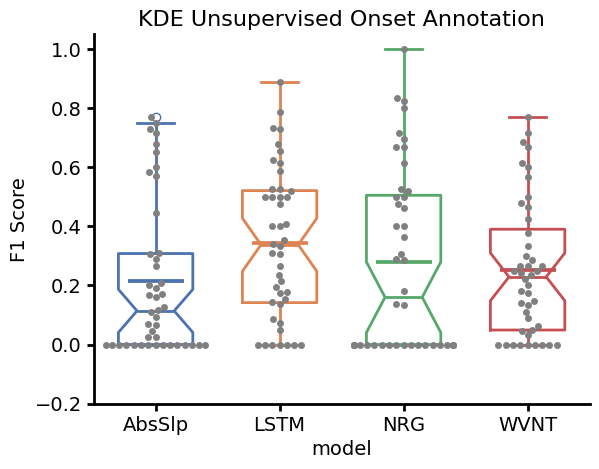

In [46]:
bx = sns.boxplot(pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y=pred_type,color='gray')
sns.pointplot(pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylabel('F1 Score')
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Onset Annotation")

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

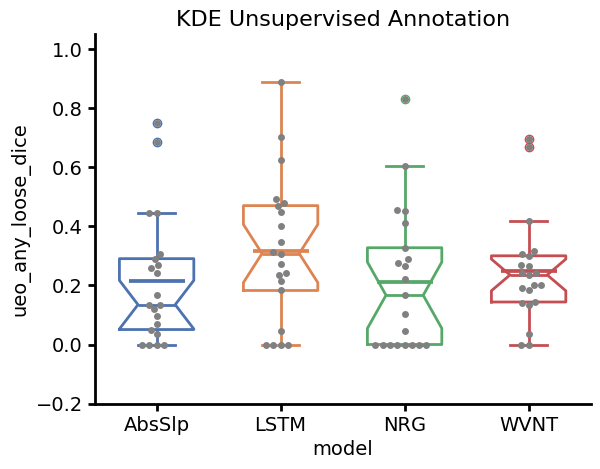

In [47]:
pt_pred_channels_wdice = pred_channels_wdice.groupby(['Patient','model'])[[pred_type]].mean().reset_index()
bx = sns.boxplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pt_pred_channels_wdice,x='model',y=pred_type,color='gray')
sns.pointplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05]) 
plt.title("KDE Unsupervised Annotation")

In [51]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        print(d)
        all_ps.append(p)
        print(p)

NRG NRG
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NRG AbsSlp
0.22728573356014015
MannwhitneyuResult(statistic=1004.5, pvalue=0.7562935042045275)
NRG WVNT
0.09592841848754705
MannwhitneyuResult(statistic=926.5, pvalue=0.727484568845689)
NRG LSTM
-0.22657483551274027
MannwhitneyuResult(statistic=785.5, pvalue=0.12316464864260182)
AbsSlp NRG
-0.22728573356014015
MannwhitneyuResult(statistic=931.5, pvalue=0.7562935042045275)
AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp WVNT
-0.1585875190685522
MannwhitneyuResult(statistic=816.5, pvalue=0.202949685828553)
AbsSlp LSTM
-0.5036175074817442
MannwhitneyuResult(statistic=668.0, pvalue=0.011758443746190101)
WVNT NRG
-0.09592841848754705
MannwhitneyuResult(statistic=1009.5, pvalue=0.727484568845689)
WVNT AbsSlp
0.1585875190685522
MannwhitneyuResult(statistic=1119.5, pvalue=0.202949685828553)
WVNT WVNT
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
WVNT LSTM
-0.3740544105659576
MannwhitneyuResult(statistic=

## Alternate Annotations

In [42]:
alt_annots = pd.read_csv(ospj(metapath,'Results_Raw_FINAL.csv'))

In [43]:
alt_onset_annots_1k = alt_annots[(alt_annots['Cutoff Frequency'] == 1000) & (alt_annots['Symbol Number'] == str(1))]
grouped_annots = alt_onset_annots_1k.groupby(['Marker','Patient File']).apply(lambda x: [y['Channel Marked'] for _,y in x.iterrows()]).reset_index()

In [44]:
all_dice = []
for i_g, group in grouped_annots.groupby('Patient File'):
    if len(group) <= 1:
        continue
    dice_val = 0
    for i_annot in range(len(group)):
        for j_annot in range(i_annot+1,len(group)):
            dice_val += dice_score(np.atleast_1d(group.iloc[i_annot,2]),np.atleast_1d(group.iloc[j_annot,2]))
    dice_val /= (len(group)*(len(group)-1))/2
    all_dice.append(dice_val)
all_dice = np.atleast_1d(all_dice)

MannwhitneyuResult(statistic=325.0, pvalue=0.863105837774294) -0.07431757056712908


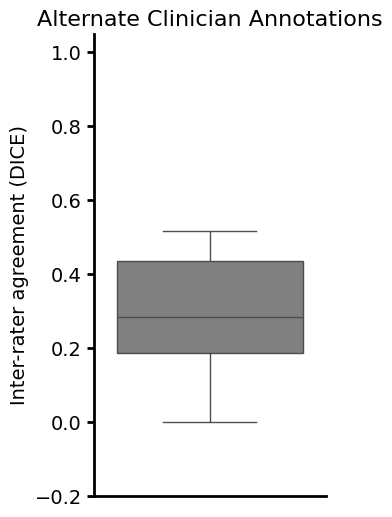

In [46]:
# all_dice = all_dice[all_dice > 0]
plt.figure(figsize=(3,6))
sns.boxplot(all_dice,color='gray')
sns.despine()
plt.title('Alternate Clinician Annotations')
plt.ylabel('Inter-rater agreement (DICE)')
plt.ylim([-.2,1.05])
plt.xticks([])

# sc.stats.mannwhitneyu(all_dice,all_plot_agreements[all_plot_agreements.model == 'LSTM'].dice),
print(sc.stats.mannwhitneyu(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))